# Cutting plane and bundle methods
The second part of the tutorial focuses on cutting plane and bundle
methods. We aim at resolving the following LASSO problem:
$$
\min_u \;f(u) =  \| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $\lambda$ a given regularization parameter, $A$ and $b$ input data.

## Table of contents <a name="toc"></a>

1. [Settings](#settings)
2. [Cuutting plane algorithm](#cutting)
3. [Bundle algorithm](#bundle)
4. [Final results on simulated data](#simulated)
    1. [First results](#res_sim)
    2. [Influence of the regularization](#reg_sim)
    3. [Impact of the normalization](#norm_sim)
5. [Final results on real data](#real)
    1. [First results](#res_real)
    2. [Influence of the regularization](#reg_real)
    3. [Impact of the normalization](#norm_real)


## Settings
We import the usual packages:

In [1]:
using Printf, Random
using LinearAlgebra
using ForwardDiff
using JuMP, CPLEX

Fix seed

In [2]:
Random.seed!(2713);

Some constants

In [3]:
const LB = 0 #For CPLEX, see note on this later on
const UB =  1e20
const SOLVER = CPLEX.Optimizer

CPLEX.Optimizer

We first generate artificial data to study the algorithm:

In [4]:
include("data.jl")

nVariables = 10;
nCassures = 10;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures);
λ = 50.0;

Build oracle for objective:

In [5]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

Function that gets the actual solution:

In [6]:
function get_solution(A, b, λ)
    n, m = size(A)
    model = Model(SOLVER)
    JuMP.set_silent(model)
    set_optimizer_attribute(model, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    # Variable u
    @variable(model, u[1:n])
    # Variable t, linearizing the \|.\|_1 term
    @variable(model, t[1:n])
    @constraint(model, t .>= u)
    @constraint(model, t .>= -u)
    @objective(model, Min, 0.5 * dot(A*u - b, A*u - b) + λ * sum(t))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end
optsol = get_solution(A, b, λ)
println("Optimal solution is equal to ", optsol)

Optimal solution is equal to 5.0541025315605985


__A note on the choice of solvers :__ 

- CPLEX (sometimes ?) does not deal very well with the very low lower bound LB. It appears that the bound is so low that it believes the problem to be unbounded (especially using the bundle method). Here we have an obvious reasonable lower bound of 0, but that might not be the case in other applications.
- OSQP, as seen in the previous practical session, seems to have numerous instability problems and sometimes a lack of convergence. Here, bundle algorithm could not converge in 5 000 iterations with OSQP while it had no issue in less than 200 iterations with CPLEX (once taken into account previous comment).

Given these observations, we have chosen to keep working with CPLEX.

_Back to [table of contents](#toc)_

## Cutting plane <a name="cutting"></a>
The cutting plane method builds a proxy $\underline{f}_k$ for the original
function $f$, such that $\underline{f}_k$ is polyhedral and is a lower approximation:
$$
\underline{f}_k \leq f \quad \forall k
$$
If we have at disposal a collection of point $x_1, \cdots, x_k$,
with associated subgradients $g_1, \cdots, g_k$, the function
$\underline{f}_k$ writes out
$$
\begin{aligned}
\underline{f}_k(x) = min_{\theta} \;& \theta  \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k) \quad \forall k
\end{aligned}
$$

We can define the cutting plane algorithm as follows.

In [7]:
function launch_cutting_plane(X, xMin, xMax, epsilon=1e-8, maxit=5000)
    
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB) 
    @variable(master, xMin[i] <= x[i in 1:size(X,1)] <= xMax[i])
    @objective(master, Min, α)
    
    lb, ub = LB, UB

    best_ub = ub
    
    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]
    
    for n_iter in 1:maxit
        #println("Iteration : ",n_iter)
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        x_k = JuMP.value.(x)
        f_k = f(x_k)
        #println("Lower bound : ", lb)
        #println("Valeur au point courant : ", f_k)
        g_k = ForwardDiff.gradient(f, x_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        if (f_k - lb <= epsilon)
            println("Optimum reached within epsilon threshold.")
            return trace_f, trace_ub, trace_lb, n_iter ;
            break
        else
            @constraint(master, α >= f_k + sum(g_k[i]*(x-x_k)[i] for i in 1:size(X,1)))
        end
    end
    println("Optimum within epsilon threshold not reached.")
    return trace_f, trace_ub, trace_lb, maxit ;
end;

_Back to [table of contents](#toc)_

## Bundle algorithm <a name="bundle"></a>
Comparing to the cutting plane method, the bundle algorithm adds a
quadratic penalization to the polyhedral proxy model.
The function .
$$
\begin{aligned}
f_k(x) = min_x \;& \theta + \frac 12 \| x - x_k \|_2^2 \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

In [8]:
function launch_bundle(X, xMin, xMax, c=0.5, maxit=5000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB)
    @variable(master, xMin[i] <= y[i in 1:size(X,1)] <= xMax[i])
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]

    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    weight = 1/(2*c)
    m = 0.1
    epsilon = 1e-8
    
    x_k = zeros(size(X,1))
    
    # The objective writes out as a QP
    @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
    
    for n_iter in 1:maxit
        JuMP.optimize!(master)
        # println("Iteration ", n_iter)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        f_k = f(y_k)
        # println("Lower bound : ", lb)
        # println("Function value : ", f_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        f_x_k = f(x_k)
        delta_k = f_x_k - lb - weight*sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        
        if delta_k <= epsilon
            println("Optimum reached within epsilon threshold.")
            println("Number of serious steps :", nb_ss)
            println("Number of null steps :", nb_ns)
            return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns ;
        else
            if f_x_k - f_k >= m*delta_k
                # Serious step
                nb_ss += 1
                # println("Serious step.")
                x_k = y_k
                # We shall redefine the objective to take into account the new center
                @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1))) 
            else
                # Null step
                # println("Null step.")
                nb_ns += 1
            end
        end
        g_k = ForwardDiff.gradient(f, y_k)
        @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
    end
    println("Optimum within epsilon threshold not reached.")
    println("Number of serious steps :", nb_ss)
    println("Number of null steps :", nb_ns)
    return trace_f, trace_ub, trace_lb, maxit, nb_ss, nb_ns ;
end;

In [9]:
function launch_bundle_poly(X, xMin, xMax, c=0.5, epsilon=1e-8, epsilon2=1e-8, maxit=5000)
    
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB)
    @variable(master, xMin[i] <= y[i in 1:size(X,1)] <= xMax[i])
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]

    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    
    weight = 1/(2*c)
    
    x_k = zeros(size(X,1))
    
    # The objective writes out as a QP
    @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
    
    for n_iter in 1:maxit
        JuMP.optimize!(master)
        # println("Iteration ", n_iter)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        f_k = f(y_k)
        # println("Lower bound : ", lb)
        # println("Function value : ", f_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        f_x_k = f(x_k)
        
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        
        if f_k - lb <= weight*sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))
            if sqrt(sum((y_k[i]-x_k[i])^2 for i in 1:size(X,1))) <= epsilon
                println("Optimum reached within epsilon threshold.")
                println("Number of serious steps :", nb_ss)
                println("Number of null steps :", nb_ns)
                return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns
            else
                # Serious step
                nb_ss += 1
                # println("Serious step.")
                x_k = y_k
                # We shall redefine the objective to take into account the new center
                @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:size(X,1)))
                g_k = ForwardDiff.gradient(f, y_k)
                @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
            end
        else
            if f_k - lb <= epsilon2
                println("Optimum reached within epsilon2 threshold.")
                println("Number of serious steps :", nb_ss)
                println("Number of null steps :", nb_ns)
                return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns ;
            else
                # Null step
                # println("Null step.")
                nb_ns += 1
                g_k = ForwardDiff.gradient(f, y_k)
                @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
            end
        end  
    end
    println("Optimum within epsilon threshold not reached.")
    println("Number of serious steps :", nb_ss)
    println("Number of null steps :", nb_ns)
    return trace_f, trace_ub, trace_lb, maxit, nb_ss, nb_ns ;
end;

__A note on bundle implementation__

We had some struggle with the implementation of the bundle algorithm. Indeed, we did not want to declare ```x_k``` as a variable in order to be closer to the original mathematic problem. We first thought that it would automatically update the objective, and we obtained good looking results. But in fact, we could check that even though we were making serious steps, ```x_k``` in the objective was still ```x_0```.


To correct this issue, we came back to the proposed implementation and declared the center ```x_k``` as a variable of the master problem, fixing it with ```JuMP.fix.```. By doing so, we were obtaining infeasible problem for some iterations. We could bypass this issue modifiying a bit the conditions of convergence, and then obtained good looking results again, but they did not have any interpretation anymore. 

Eventually, we came back to our first idea and in addition updated the objective in the serious step in order to take into account the update of the center ```x_k```. Eventhough it seems equivalent in practice with ```x_k``` being declared as a variable of the problem and then fixed, it seems that it is not equivalent for the solver. This could be explained by the fact that for the solver ```x_k``` is a variable even if fixed, and it induces it to some comportment in its solution search that is different to when ```x_k``` is just some constant in the objective to the solver.

_Back to [table of contents](#toc)_

## Final results on simulated data <a name="simulated"></a>


In [11]:
trace_cutting_plane_f, trace_cutting_plane_ub, trace_cutting_plane_lb, n_cutting_plane  = launch_cutting_plane(A,xMin,xMax) ;

Optimum within epsilon threshold not reached.


In [12]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - trace_cutting_plane_lb[length(trace_cutting_plane_lb)]

7.932302077406916e-7

The algorithm did not reach a gap of $10^{-8}$, but still it is not that bad with a gap of $10^{-6}$

In [13]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - optsol

5.481407541196859e-7

In [16]:
trace_bundle_f, trace_bundle_ub, trace_bundle_lb, n_bundle, nb_ss, nb_ns = launch_bundle(A,xMin,xMax) ;

Optimum reached within epsilon threshold.
Number of serious steps :39
Number of null steps :156


In [23]:
trace_bundle_f[length(trace_bundle_f)] - optsol

1.6363385313411527e-8

A first conclusion is that the bundle algorithm seems (at least with this data and this problem) more precise than the cutting plane algorithm. It is consistent with their design. 

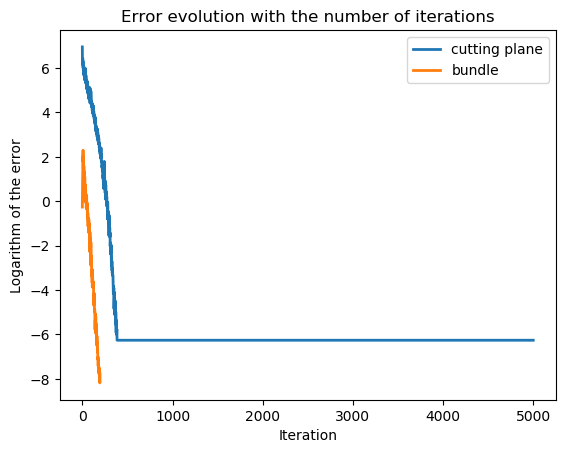

PyObject <matplotlib.legend.Legend object at 0x14c2b5d50>

In [24]:
plot(log10.(trace_cutting_plane_f .- optsol), lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

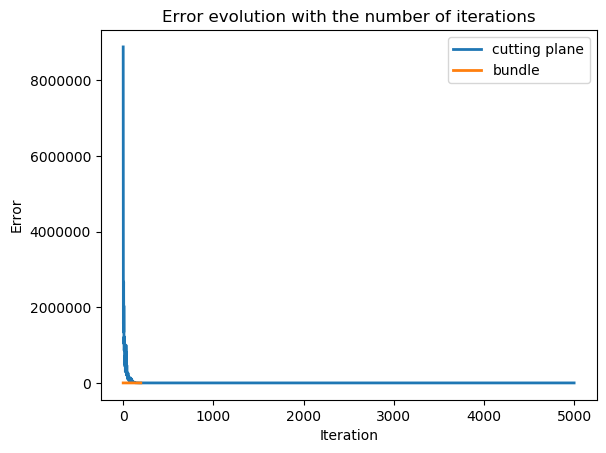

PyObject <matplotlib.legend.Legend object at 0x164122e50>

In [25]:
plot(trace_cutting_plane_f .- optsol, lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()

We have the graphical impression that the cutting plane algorithm stagnates after something like 500 iterations. We can check this:

In [50]:
findlast(isequal(0),((trace_cutting_plane_f .- trace_cutting_plane_f[length(trace_cutting_plane_f)]) .== 0))

385

Hence, after the iteration number 386 the algorithm stayed on the same point. Thus, we can't reach a better prevision than $10^{-6}$ even if we increase $\epsilon$ or ```maxit```.

Even if we only take into account these 386 first iterations, the bundle algorithm is faster, and creates less cuts than the cutting plane algorithm, again as expected. Indeed, the bundel algorithm generated: 

In [53]:
println(n_bundle)

196


which is really less than 386.

We can zoom on the first 386 iterations:

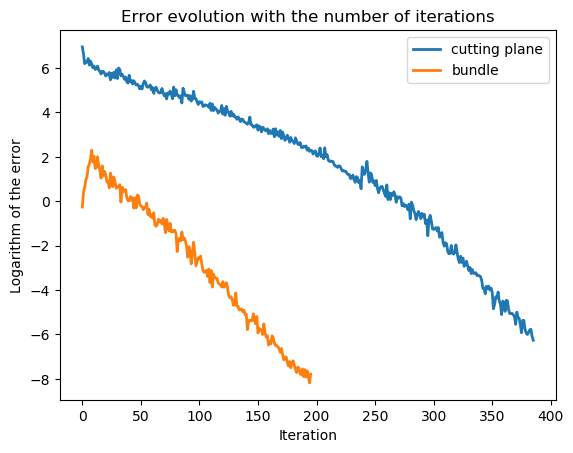

PyObject <matplotlib.legend.Legend object at 0x1666d7350>

In [51]:
plot(log10.(trace_cutting_plane_f .- optsol)[1:386], lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

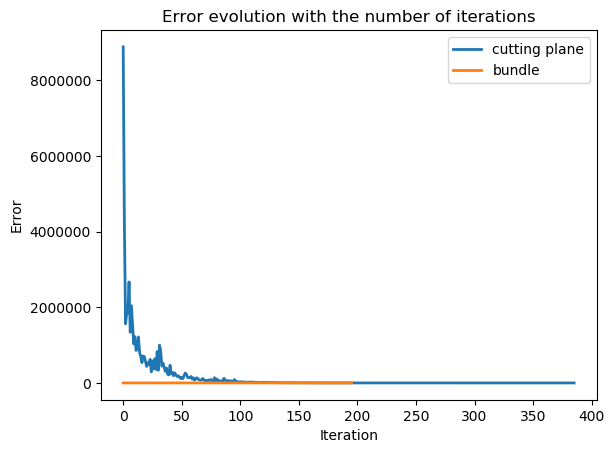

PyObject <matplotlib.legend.Legend object at 0x166709e90>

In [52]:
plot((trace_cutting_plane_f .- optsol)[1:386], lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()

We observe that from the beginning on, the approximation supplied by the bundle algorithm was far better than the one obtained thanks to the cutting plane algorithm. Furthermore, not only the bundle algorithm converges faster and more precisely, the rate of decrease is also higher (we observe this on the log plot): it is not only because it starts earlier with a good point, its improvements are indeed better at each step thanks to the Moreau-Yosida regularization.

_Back to [table of contents](#toc)_

### Influence of the tightness c

In [ ]:
c_min = -5 ;
c_max = 3 ;
lambdas = [5*(float(10)^(i)) for i in range(e_min,e_max, step=1)]

trace_prox = Float64[]
trace_prox_acc = Float64[]

for λ in lambdas

    optsol = get_solution(A, b, λ)
    
    trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox, trace_1[length(trace_1)] - optsol)
    trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox_acc, trace_2[length(trace_2)] - optsol)
    
end

plot(log10.(abs.(trace_prox)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_prox_acc)), lw=2., label="Accelerated gradient")
xticks(range(0,length(lambdas),step=1),lambdas)
xlabel("λ")
ylabel("Logarithm of the error")
title("Influence of the regularization strength on the error")
legend()

In [37]:
smallprimes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29];

In [40]:
findall(isequal(13), smallprimes)

1-element Array{Int64,1}:
 6